In [ ]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


## Define VAE without GAP

In [13]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=((18,18,64)))
    out = z_mean + K.exp(z_log_sigma) * epsilon
    return out

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss


latent_dim=64
input_shape=(18,18,736)
batch_size=32

x = Input(shape=(input_shape), name='input')

h = Dense(256, activation='relu', name='h')(x)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

z = Lambda(sampling, name='lambda_sampling')([z_mean,z_log_sigma])

decoder_h = Dense(256, activation='relu', name='decoder_h')
decoder_mean = Dense(736, activation='sigmoid', name='decoder_mean')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)

decoder_input = Input(shape=(18,18,64))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

vae.compile(optimizer='rmsprop', loss=vae_loss)




In [14]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 18, 18, 256)  188672      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 18, 18, 64)   16448       h[0][0]                          
__________________________________________________________________________________________________
lambda_sam

In [90]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [83]:
with open('/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

# with open('/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
#     _, t_features = pickle.load(dt)

s_labels = [k.split('/')[-2] for k in s_labels]
sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
s_features.shape, sval_features.shape, t_features.shape

((1576, 18, 18, 736), (395, 18, 18, 736), (444, 18, 18, 736))

## Amazon

In [6]:
mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/vae_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=50, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/vae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 1576 samples, validate on 395 samples
Epoch 1/50
1576/1576 [==============================] - 3s 2ms/step - loss: 0.1089 - val_loss: -0.7377
Epoch 2/50
1576/1576 [==============================] - 3s 2ms/step - loss: -0.7427 - val_loss: -1.1327
Epoch 3/50
1576/1576 [==============================] - 3s 2ms/step - loss: -1.1833 - val_loss: -1.5754
Epoch 4/50
1576/1576 [==============================] - 3s 2ms/step - loss: -1.5095 - val_loss: -1.8297
Epoch 5/50
1576/1576 [==============================] - 3s 2ms/step - loss: -1.6983 - val_loss: -1.9990
Epoch 6/50
1576/1576 [==============================] - 3s 2ms/step - loss: -1.8531 - val_loss: -2.1383
Epoch 7/50
1576/1576 [==============================] - 3s 2ms/step - loss: -2.0002 - val_loss: -2.3003
Epoch 8/50
1576/1576 [==============================] - 3s 2ms/step - loss: -2.1424 - val_loss: -2.4080
Epoch 9/50
1576/1576 [==============================] - 3s 2ms/step - loss: -2.2528 - val_loss: -2.5243
Epoch 10/50
1576/1

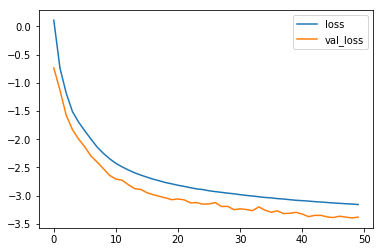

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Webcam

In [16]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/vae_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/webcam/vae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 0.8699 - val_loss: 0.6652
Epoch 2/100
444/444 [==============================] - 1s 2ms/step - loss: 0.6555 - val_loss: 0.6290
Epoch 3/100
444/444 [==============================] - 1s 2ms/step - loss: 0.6202 - val_loss: 0.5526
Epoch 4/100
444/444 [==============================] - 1s 2ms/step - loss: 0.4931 - val_loss: 0.4043
Epoch 5/100
444/444 [==============================] - 1s 2ms/step - loss: 0.3830 - val_loss: 0.3347
Epoch 6/100
444/444 [==============================] - 1s 2ms/step - loss: 0.3364 - val_loss: 0.2913
Epoch 7/100
444/444 [==============================] - 1s 2ms/step - loss: 0.3106 - val_loss: 0.3137
Epoch 8/100
444/444 [==============================] - 1s 2ms/step - loss: 0.2996 - val_loss: 0.2715
Epoch 9/100
444/444 [==============================] - 1s 2ms/step - loss: 0.2838 - val_loss: 0.2532
Epoch 10/100
444/444 [=======================

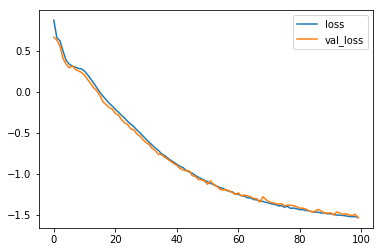

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [19]:
import keras.losses
keras.losses.vae_loss = vae_loss

## Define combined vae (t_encoder + s_decoder)

In [33]:
s_vae = load_model('/data/Quan/tf_models/amazon/vae_model.hdf5')
t_vae = load_model('/data/Quan/tf_models/webcam/vae_model.hdf5')

t_encoder = Model(t_vae.input, [t_vae.layers[2].output, t_vae.layers[3].output])

In [38]:
_input_z = Input(shape=(18,18,64))
_input_z_log_mean = Input(shape=(18,18,64))

s_z = Lambda(sampling, name='lambda_sampling')([_input_z,_input_z_log_mean])
s_h_decoded = decoder_h(s_z)
s_x_decoded_mean = decoder_mean(s_h_decoded)

s_decoder = Model([_input_z, _input_z_log_mean], s_x_decoded_mean)

# set weights from amazon vae decoder
for i in range(3, len(s_decoder.layers)):
    s_decoder.layers[i].set_weights(s_vae.layers[i+2].get_weights())

In [39]:
# combine webcam encoder + amazon decoder

_c_input = Input(shape=(18,18,736))
_t_encoder = t_encoder(_c_input)
_s_decoder = s_decoder(_t_encoder)

combine_vae = Model(_c_input, _s_decoder)
combine_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
model_13 (Model)                [(None, 18, 18, 64), 221568      input_15[0][0]                   
__________________________________________________________________________________________________
model_17 (Model)                (None, 18, 18, 736)  205792      model_13[1][0]                   
                                                                 model_13[1][1]                   
Total params: 427,360
Trainable params: 427,360
Non-trainable params: 0
__________________________________________________________________________________________________


## Mapping t_features to s_features using combined vae

In [41]:
transformed_features = combine_vae.predict(s_features, verbose=1)
transformed_features.shape

444/444 [==============================] - 1s 2ms/step


(444, 18, 18, 736)

In [42]:
val_transformed_features = combine_vae.predict(sval_features, verbose=1)
val_transformed_features.shape

112/112 [==============================] - 0s 2ms/step


(112, 18, 18, 736)

In [61]:
with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    t_test_labels, t_test_features = pickle.load(dt)
    
t_test_labels = [label_dict[k] for k in t_test_labels]
t_test_labels = keras.utils.to_categorical(t_test_labels, 31)

In [62]:
test_transformed_features = combine_vae.predict(t_test_features, verbose=1)
test_transformed_features.shape

239/239 [==============================] - 1s 4ms/step


(239, 18, 18, 736)

In [76]:
# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-5,0):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i+6].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 736)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_3 (Batch (None, 31)                124       
_________________________________________________________________
activation_3 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [59]:
num_s_labels = [label_dict[k] for k in s_labels]
num_sval_labels = [label_dict[k] for k in sval_labels]

num_s_labels = keras.utils.to_categorical(num_s_labels, 31)
num_sval_labels = keras.utils.to_categorical(num_sval_labels, 31)

In [63]:
s_topmodel.evaluate(test_transformed_features, t_test_labels, verbose=1)

239/239 [==============================] - 1s 2ms/step


[3.8848912067493138, 0.016736401673640166]

In [77]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transformed_features, num_s_labels, batch_size=32, epochs=100,
               validation_data=(val_transformed_features, num_sval_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 2s 5ms/step - loss: 4.6792 - acc: 0.0293 - val_loss: 2.9964 - val_acc: 0.1429
Epoch 2/100
444/444 [==============================] - 0s 452us/step - loss: 3.5329 - acc: 0.1261 - val_loss: 2.3392 - val_acc: 0.2857
Epoch 3/100
444/444 [==============================] - 0s 475us/step - loss: 2.8008 - acc: 0.2365 - val_loss: 1.9336 - val_acc: 0.4375
Epoch 4/100
444/444 [==============================] - 0s 434us/step - loss: 2.2837 - acc: 0.3288 - val_loss: 1.6886 - val_acc: 0.4911
Epoch 5/100
444/444 [==============================] - 0s 448us/step - loss: 2.0238 - acc: 0.4032 - val_loss: 1.5372 - val_acc: 0.5357
Epoch 6/100
444/444 [==============================] - 0s 455us/step - loss: 1.6969 - acc: 0.4955 - val_loss: 1.4297 - val_acc: 0.5357
Epoch 7/100
444/444 [==============================] - 0s 452us/step - loss: 1.4900 - acc: 0.5653 - val_loss: 1.3400 - val_acc: 0.5446
Epoch 8/100

Epoch 61/100
444/444 [==============================] - 0s 434us/step - loss: 0.4434 - acc: 0.9324 - val_loss: 0.5873 - val_acc: 0.8482
Epoch 62/100
444/444 [==============================] - 0s 434us/step - loss: 0.4157 - acc: 0.9279 - val_loss: 0.5876 - val_acc: 0.8482
Epoch 63/100
444/444 [==============================] - 0s 440us/step - loss: 0.4466 - acc: 0.9212 - val_loss: 0.5855 - val_acc: 0.8482
Epoch 64/100
444/444 [==============================] - 0s 436us/step - loss: 0.4349 - acc: 0.9144 - val_loss: 0.5868 - val_acc: 0.8482
Epoch 65/100
444/444 [==============================] - 0s 434us/step - loss: 0.4757 - acc: 0.8986 - val_loss: 0.5862 - val_acc: 0.8482
Epoch 66/100
444/444 [==============================] - 0s 434us/step - loss: 0.4580 - acc: 0.9212 - val_loss: 0.5828 - val_acc: 0.8393
Epoch 67/100
444/444 [==============================] - 0s 434us/step - loss: 0.4502 - acc: 0.9212 - val_loss: 0.5852 - val_acc: 0.8393
Epoch 68/100
444/444 [==========================

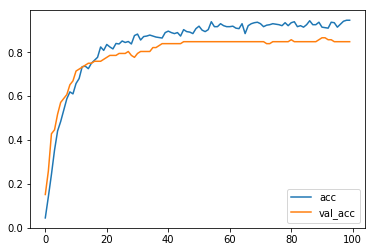

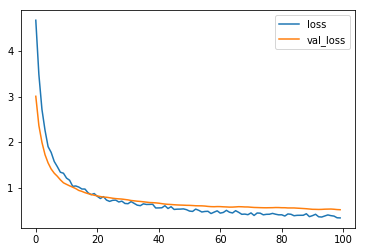

In [74]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [75]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier_model.hdf5')
test_topmodel.evaluate(test_transformed_features, t_test_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[0.6694457146911941, 0.8284518833439719]

## Define VAE with GAP

In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=((64,)))
    out = z_mean + K.exp(z_log_sigma) * epsilon
    return out

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss


latent_dim=64
input_shape=(18,18,736)
batch_size=32

x = Input(shape=(input_shape), name='input')
h = GlobalAveragePooling2D(name='global_average_pooling')(x)
h = Dense(256, activation='relu', name='h')(h)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

z = Lambda(sampling, name='lambda_sampling')([z_mean,z_log_sigma])

decoder_h = Dense(256, activation='relu', name='decoder_h')
decoder_mean = Dense(736, activation='sigmoid', name='decoder_mean')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)
# print(encoder.summary())

decoder_input = Input(shape=(64,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
global_average_pooling (GlobalA (None, 736)          0           input[0][0]                      
__________________________________________________________________________________________________
h (Dense)                       (None, 256)          188672      global_average_pooling[0][0]     
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigm

## Webcam

In [10]:
in_g = Input(shape=(18,18,736))
g = GlobalAveragePooling2D()(in_g)
util_gap = Model(in_g, g)
util_gap.compile(optimizer='adam', loss=binary_crossentropy)

s_gap_features = util_gap.predict(s_features)
sval_gap_features = util_gap.predict(sval_features)

s_gap_features.shape, sval_gap_features.shape

((444, 736), (112, 736))

In [12]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/vae_gap_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_gap_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_gap_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/webcam/vae_gap_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 2ms/step - loss: 0.7517 - val_loss: 0.6484
Epoch 2/100
444/444 [==============================] - 0s 679us/step - loss: 0.6476 - val_loss: 0.6263
Epoch 3/100
444/444 [==============================] - 0s 675us/step - loss: 0.6378 - val_loss: 0.6234
Epoch 4/100
444/444 [==============================] - 0s 676us/step - loss: 0.6372 - val_loss: 0.6205
Epoch 5/100
444/444 [==============================] - 0s 674us/step - loss: 0.6332 - val_loss: 0.6158
Epoch 6/100
444/444 [==============================] - 0s 675us/step - loss: 0.6311 - val_loss: 0.6089
Epoch 7/100
444/444 [==============================] - 0s 680us/step - loss: 0.6315 - val_loss: 0.6142
Epoch 8/100
444/444 [==============================] - 0s 675us/step - loss: 0.6287 - val_loss: 0.6077
Epoch 9/100
444/444 [==============================] - 0s 673us/step - loss: 0.6285 - val_loss: 0.6090
Epoch 10/100
444/444 [=======

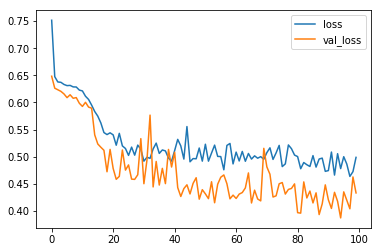

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Amazon

In [15]:
in_g = Input(shape=(18,18,736))
g = GlobalAveragePooling2D()(in_g)
util_gap = Model(in_g, g)
util_gap.compile(optimizer='adam', loss=binary_crossentropy)

s_gap_features = util_gap.predict(s_features)
sval_gap_features = util_gap.predict(sval_features)

s_gap_features.shape, sval_gap_features.shape

((1576, 736), (395, 736))

In [16]:
mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/vae_gap_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_gap_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_gap_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/vae_gap_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 1s 736us/step - loss: -0.2846 - val_loss: -0.5483
Epoch 2/100
1576/1576 [==============================] - 1s 731us/step - loss: -0.4076 - val_loss: -0.5796
Epoch 3/100
1576/1576 [==============================] - 1s 734us/step - loss: -0.4509 - val_loss: -0.6638
Epoch 4/100
1576/1576 [==============================] - 1s 736us/step - loss: -0.5077 - val_loss: -0.5312
Epoch 5/100
1576/1576 [==============================] - 1s 737us/step - loss: -0.5620 - val_loss: -0.6930
Epoch 6/100
1576/1576 [==============================] - 1s 731us/step - loss: -0.6301 - val_loss: -0.8055
Epoch 7/100
1576/1576 [==============================] - 1s 734us/step - loss: -0.6404 - val_loss: -0.8663
Epoch 8/100
1576/1576 [==============================] - 1s 733us/step - loss: -0.6988 - val_loss: -0.9146
Epoch 9/100
1576/1576 [==============================] - 1s 739us/step - loss: -0.7127 - val_loss

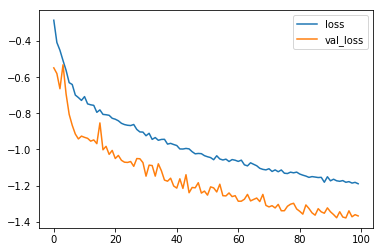

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Define combined vae (t_encoder + s_decoder)

In [25]:
s_vae = load_model('/data/Quan/tf_models/amazon/vae_gap_model.hdf5')
t_vae = load_model('/data/Quan/tf_models/webcam/vae_gap_model.hdf5')

t_encoder = Model(t_vae.input, [t_vae.layers[3].output, t_vae.layers[4].output])

In [27]:
_input_z = Input(shape=(64,))
_input_z_log_mean = Input(shape=(64,))

s_z = Lambda(sampling, name='lambda_sampling')([_input_z,_input_z_log_mean])
s_h_decoded = decoder_h(s_z)
s_x_decoded_mean = decoder_mean(s_h_decoded)

s_decoder = Model([_input_z, _input_z_log_mean], s_x_decoded_mean)

# set weights from amazon vae decoder
for i in range(-2, 0):
    s_decoder.layers[i].set_weights(s_vae.layers[i].get_weights())

In [28]:
# combine webcam encoder + amazon decoder

_c_input = Input(shape=(18,18,736))
_t_encoder = t_encoder(_c_input)
_s_decoder = s_decoder(_t_encoder)

combine_vae = Model(_c_input, _s_decoder)
combine_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
model_20 (Model)                [(None, 64), (None,  221568      input_14[0][0]                   
__________________________________________________________________________________________________
model_21 (Model)                (None, 736)          205792      model_20[1][0]                   
                                                                 model_20[1][1]                   
Total params: 427,360
Trainable params: 427,360
Non-trainable params: 0
__________________________________________________________________________________________________


## Mapping t_features to s_features using combined vae

In [33]:
transformed_features = combine_vae.predict(s_features, verbose=1)
transformed_features.shape

444/444 [==============================] - 0s 773us/step


(444, 736)

In [34]:
val_transformed_features = combine_vae.predict(sval_features, verbose=1)
val_transformed_features.shape

112/112 [==============================] - 0s 456us/step


(112, 736)

In [37]:
label_dict = test_generator.class_indices

with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    t_test_labels, t_test_features = pickle.load(dt)
    
t_test_labels = [label_dict[k] for k in t_test_labels]
t_test_labels = keras.utils.to_categorical(t_test_labels, 31)

In [38]:
test_transformed_features = combine_vae.predict(t_test_features, verbose=1)
test_transformed_features.shape

239/239 [==============================] - 0s 921us/step


(239, 736)

In [41]:
# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(736,))
x = Dropout(0.3)(input_model)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-4,0):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i+5].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 736)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_2 (Batch (None, 31)                124       
_________________________________________________________________
activation_2 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [42]:
num_s_labels = [label_dict[k] for k in s_labels]
num_sval_labels = [label_dict[k] for k in sval_labels]

num_s_labels = keras.utils.to_categorical(num_s_labels, 31)
num_sval_labels = keras.utils.to_categorical(num_sval_labels, 31)

In [43]:
s_topmodel.evaluate(test_transformed_features, t_test_labels, verbose=1)

239/239 [==============================] - 1s 4ms/step


[4.356281603729376, 0.02092050209205021]

In [44]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_gap_classifier_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transformed_features, num_s_labels, batch_size=32, epochs=100,
               validation_data=(val_transformed_features, num_sval_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_gap_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 4.5042 - acc: 0.0338 - val_loss: 3.6164 - val_acc: 0.0268
Epoch 2/100
444/444 [==============================] - 0s 83us/step - loss: 3.2948 - acc: 0.1532 - val_loss: 3.6839 - val_acc: 0.0446
Epoch 3/100
444/444 [==============================] - 0s 80us/step - loss: 2.5867 - acc: 0.2252 - val_loss: 3.7371 - val_acc: 0.0625
Epoch 4/100
444/444 [==============================] - 0s 81us/step - loss: 2.1544 - acc: 0.3288 - val_loss: 3.7696 - val_acc: 0.0714
Epoch 5/100
444/444 [==============================] - 0s 81us/step - loss: 1.9385 - acc: 0.3806 - val_loss: 3.7702 - val_acc: 0.0714
Epoch 6/100
444/444 [==============================] - 0s 80us/step - loss: 1.7624 - acc: 0.4550 - val_loss: 3.7504 - val_acc: 0.0804
Epoch 7/100
444/444 [==============================] - 0s 81us/step - loss: 1.7050 - acc: 0.4527 - val_loss: 3.7449 - val_acc: 0.1071
Epoch 8/100
444/4

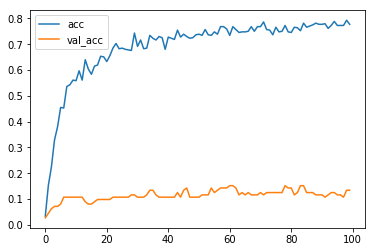

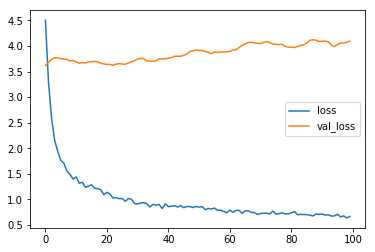

In [45]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [46]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_gap_classifier_model.hdf5')
test_topmodel.evaluate(test_transformed_features, t_test_labels, verbose=1)

239/239 [==============================] - 0s 2ms/step


[4.492340698401798, 0.04602510460251046]

## Subtract the latent space for s data and t data

In [71]:
s_vae = load_model('/data/Quan/tf_models/amazon/vae_model.hdf5')
t_vae = load_model('/data/Quan/tf_models/webcam/vae_model.hdf5')

t_encoder = Model(t_vae.input, [t_vae.layers[2].output, t_vae.layers[3].output])
s_encoder = Model(s_vae.input, [s_vae.layers[2].output, s_vae.layers[3].output])

In [62]:
s_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
global_average_pooling (GlobalA (None, 736)          0           input[0][0]                      
__________________________________________________________________________________________________
h (Dense)                       (None, 256)          188672      global_average_pooling[0][0]     
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigm

In [61]:
s_input_z = Input(shape=(18,18,64))
s_input_z_log_mean = Input(shape=(18,18,64))
t_input_z = Input(shape=(18,18,64))
t_input_z_log_mean = Input(shape=(18,18,64))

s_z = Lambda(sampling, name='s_lambda_sampling')([s_input_z,s_input_z_log_mean])
t_z = Lambda(sampling, name='t_lambda_sampling')([t_input_z,t_input_z_log_mean])

subtract_z = Subtract()([s_z, t_z])
# subtract_z = Activation('sigmoid')

s_subtract_h_decoded = Dense(256, activation='relu', name='s_decoder_subtract_h')(subtract_z)
s_subtract_x_decoded_mean = Dense(736, activation='sigmoid', name='s_decoder_subtract_mean')(s_subtract_h_decoded) #output

t_subtract_h_decoded = Dense(256, activation='relu', name='t_decoder_subtract_h')(subtract_z)
t_subtract_x_decoded_mean = Dense(736, activation='sigmoid', name='t_decoder_subtract_mean')(t_subtract_h_decoded) #output

s_h_decoded = Dense(256, activation='relu', name='s_decoder_h')(t_z)
s_x_decoded_mean = Dense(736, activation='sigmoid', name='s_decoder_mean')(s_h_decoded) #output

combined_decoder = Model([s_input_z, s_input_z_log_mean, t_input_z, t_input_z_log_mean], [s_x_decoded_mean, s_subtract_x_decoded_mean, t_subtract_x_decoded_mean])
combined_decoder.summary()
# set weights from amazon vae decoder
# for i in range(3, len(s_decoder.layers)):
#     s_decoder.layers[i].set_weights(s_vae.layers[i+2].get_weights())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 18, 18, 64)   0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           (None, 18, 18, 64)   0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           (None, 18, 18, 64)   0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 18, 18, 64)   0                                            
__________________________________________________________________________________________________
t_lambda_s

In [68]:
i = -4
k = -2
combined_decoder.layers[i].set_weights(t_vae.layers[k].get_weights())

In [87]:
# combine webcam encoder + amazon decoder

_s_c_input = Input(shape=(18,18,736))
_t_c_input = Input(shape=(18,18,736))

_t_encoder = t_encoder(_t_c_input)
_s_encoder = s_encoder(_s_c_input)

_s_decoded_mean, s_subtract_mean, t_subtract_mean = combined_decoder([_s_encoder[0],_s_encoder[1], 
                                                                      _t_encoder[0], _t_encoder[1]])
concat = concatenate([_s_decoded_mean, s_subtract_mean, t_subtract_mean])

combine_vae = Model([_s_c_input, _t_c_input], concat)
combine_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
input_73 (InputLayer)           (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
model_31 (Model)                [(None, 18, 18, 64), 221568      input_72[0][0]                   
__________________________________________________________________________________________________
model_30 (Model)                [(None, 18, 18, 64), 221568      input_73[0][0]                   
__________________________________________________________________________________________________
model_29 (

## Mapping using combined vae

In [88]:
transformed_features, s_subtract, t_subtract = combine_vae.predict([s_features[:444], t_features], verbose=1)
transformed_features.shape, s_subtract.shape, t_subtract.shape

444/444 [==============================] - 2s 5ms/step


((444, 18, 18, 2208), (444, 18, 18, 736), (444, 18, 18, 736))

In [89]:
val_transformed_features = combine_vae.predict([sval_features[:112], tval_features], verbose=1)
val_transformed_features.shape

112/112 [==============================] - 0s 3ms/step


(112, 18, 18, 2208)

In [93]:
label_dict = test_generator.class_indices

with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    t_test_labels, t_test_features = pickle.load(dt)
    
t_test_labels = [label_dict[k] for k in t_test_labels]
t_test_labels = keras.utils.to_categorical(t_test_labels, 31)

In [95]:
test_transformed_features = combine_vae.predict(t_test_features, verbose=1)
test_transformed_features.shape

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[5.81216216e-01, 2.03334764e-01, 3.85966659e-01, ...,
          1.37898469e+00, 2.18067765e+00, 2.43087721e+00],
         [7.76952386e-01, 0.00000000e+00, 1.08271100e-01, ...,
          1.74...

In [101]:
# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,2208))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

# for i in range(-3,-1):
# #     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
#     s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [ ]:
s_s_baseline.predict(s_features, verbose=1)

In [97]:
num_s_labels = [label_dict[k] for k in s_labels]
num_sval_labels = [label_dict[k] for k in sval_labels]

num_s_labels = keras.utils.to_categorical(num_s_labels, 31)
num_sval_labels = keras.utils.to_categorical(num_sval_labels, 31)

In [63]:
s_topmodel.evaluate(test_transformed_features, t_test_labels, verbose=1)

239/239 [==============================] - 1s 2ms/step


[3.8848912067493138, 0.016736401673640166]

In [103]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_2inputs_classifier_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transformed_features, num_s_labels[:444], batch_size=32, epochs=100,
               validation_data=(val_transformed_features, num_sval_labels[:112]), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_2inputs_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 5s 11ms/step - loss: 3.4720 - acc: 0.0766 - val_loss: 3.4648 - val_acc: 0.1964
Epoch 2/100
444/444 [==============================] - 1s 3ms/step - loss: 2.7700 - acc: 0.2635 - val_loss: 3.4457 - val_acc: 0.1875
Epoch 3/100
444/444 [==============================] - 1s 3ms/step - loss: 2.3718 - acc: 0.4775 - val_loss: 3.4148 - val_acc: 0.1786
Epoch 4/100
444/444 [==============================] - 1s 3ms/step - loss: 2.2357 - acc: 0.5811 - val_loss: 3.3853 - val_acc: 0.1607
Epoch 5/100
444/444 [==============================] - 1s 3ms/step - loss: 2.1100 - acc: 0.6194 - val_loss: 3.3777 - val_acc: 0.1518
Epoch 6/100
444/444 [==============================] - 1s 3ms/step - loss: 2.0194 - acc: 0.6847 - val_loss: 3.3709 - val_acc: 0.1607
Epoch 7/100
444/444 [==============================] - 1s 3ms/step - loss: 1.9245 - acc: 0.6824 - val_loss: 3.3714 - val_acc: 0.1607
Epoch 8/100
444/444 [=

Epoch 62/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6539 - acc: 0.9009 - val_loss: 3.1480 - val_acc: 0.1607
Epoch 63/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6890 - acc: 0.8716 - val_loss: 3.1516 - val_acc: 0.1607
Epoch 64/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6625 - acc: 0.8896 - val_loss: 3.1376 - val_acc: 0.1696
Epoch 65/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6753 - acc: 0.8851 - val_loss: 3.1416 - val_acc: 0.1786
Epoch 66/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6461 - acc: 0.8851 - val_loss: 3.1453 - val_acc: 0.1696
Epoch 67/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6426 - acc: 0.8874 - val_loss: 3.1065 - val_acc: 0.1696
Epoch 68/100
444/444 [==============================] - 1s 3ms/step - loss: 0.6559 - acc: 0.8716 - val_loss: 3.1150 - val_acc: 0.1250
Epoch 69/100
444/444 [==============================] - 1s 3ms

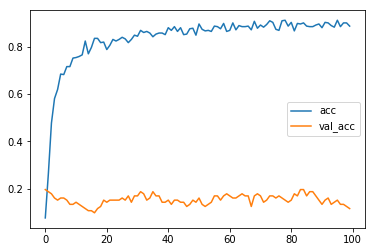

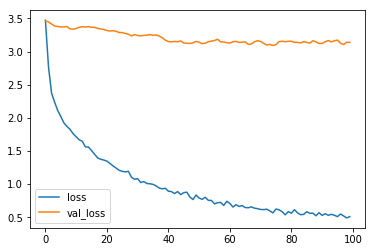

In [104]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()